# InceptionTime Model 
# on Time Series EMG Classification on Ninapro Dataset

InceptionTime is a 1D Convolution based Deep Neural Network model which is currently quoted as the state of the art TSC model from the published paper [InceptionTime: Finding AlexNet for Time Series Classification](https://arxiv.org/abs/1909.04939).

Three types of Deep Neural Network model where implemented for a Time Series Classification problem(TSC).
#### Understanding Data


#### Model Accuracy  Results

### Choosing labels

In [83]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob
import warnings
# warnings.filterwarnings(action='once')
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

## Import the Datasets to Dataframe

In [84]:
# drop_list = ['Frame', 'Sub Frame', 'IM EMG9', 'IM EMG10', 'IM EMG11', 'IM EMG12','IM EMG13', 'IM EMG14', 'IM EMG15', 'IM EMG16']
drop_list = ['Frame','Sub Frame' ,'IM EMG1','IM EMG3', 'IM EMG8' ,'IM EMG9', 'IM EMG10', 'IM EMG11', 'IM EMG12','IM EMG13', 'IM EMG14', 'IM EMG15', 'IM EMG16']

def get_emg_df(file):
    df = pd.read_csv(file)
    df = df.dropna()
    df = df.drop(drop_list,1)
    return df   

def get_pronation_radial_files(folder):
    files = glob.glob(folder+'/*.csv')
    pronation_files = []
    radial_files = []
    for file in files:
        if 'Cup' in file:
            radial_files.append(file)
        if 'Hammer' in file:
            radial_files.append(file)
        if 'ScrewDriver' in file:
            pronation_files.append(file)
        if 'Pulley' in file:
            pronation_files.append(file)
    print('Pronation Files-',len(pronation_files))
    print('Radial Files-',len(radial_files))
    return pronation_files,radial_files

def get_pronation_radial_dataframe(folder):
    pronation_files,radial_files = get_pronation_radial_files(folder)
    pronation_df_list = []
    radial_df_list = []
    for file in pronation_files:
        pronation_df_list.append(get_emg_df(file))
    for file in radial_files:
        radial_df_list.append(get_emg_df(file))
    radial_df = pd.concat(radial_df_list)
    pronation_df = pd.concat(pronation_df_list)
    print('Done Generating DFs')
    return pronation_df,radial_df

## Import all Data files to DF

In [85]:
pronation_df,radial_df = get_pronation_radial_dataframe('EMG')

Pronation Files- 100
Radial Files- 98
Done Generating DFs


### Labelling - [Pronation = 0] [Radial = 1]

In [95]:
n_pronation = pronation_df.shape[0]
n_radial = radial_df.shape[0]
# pronation_df['Label'] = np.zeros(n_pronation)
# radial_df['Label'] = np.ones(n_radial)
pronation_df['Label'] = ['Pronation']*n_pronation
radial_df['Label'] = ['Radial']*n_radial

In [96]:
print(pronation_df.shape)
pronation_df.head()

(6614180, 6)


,IM EMG2,IM EMG4,IM EMG5,IM EMG6,IM EMG7,Label
0,-0.000013,-0.000006,-0.000009,0.000014,-0.000038,Pronation
1,0.000004,0.000003,-0.000007,0.000016,-0.000038,Pronation
2,0.000004,0.000003,-0.000007,0.000016,-0.000038,Pronation
3,-0.000008,-0.000004,-0.000008,0.000014,-0.000044,Pronation
4,-0.000008,-0.000004,-0.000008,0.000014,-0.000044,Pronation


In [97]:
print(radial_df.shape)
radial_df.head()

(2969208, 6)


,IM EMG2,IM EMG4,IM EMG5,IM EMG6,IM EMG7,Label
0,-0.000020,0.000006,-0.000031,9.829880e-06,-0.000023,Radial
1,-0.000005,0.000005,-0.000021,5.743290e-07,-0.000022,Radial
2,-0.000005,0.000005,-0.000021,5.743290e-07,-0.000022,Radial
3,-0.000034,0.000005,-0.000022,-4.530290e-06,-0.000018,Radial
4,-0.000034,0.000005,-0.000022,-4.530290e-06,-0.000018,Radial


### No Normalization (Method 2) [Works]

In [98]:
pronation_df_normalized = pronation_df.drop(['Label'],1)
radial_df_normalized = radial_df.drop(['Label'],1)

### Normalization of data by sequence (Method 1)
Normalize w.r.t every 20 steps of data because while implementing this classifier model in realtime system with 20khz frequency, the incoming (20 steps X 5 feature) input can only be normalized within itself.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def norm_sequence(df,n_steps):
    array_df = df.reset_index(drop=True)
    array_df = array_df.drop(['Label'],1)
    outside = array_df.shape[0]%n_steps  # Check data points outside window
    if outside>0:
        array_df = array_df.drop(array_df.tail(outside).index,0) # Remove data points outside window
    scaler = MinMaxScaler()
    ndata = array_df.loc[0:n_steps-1].values
    scaler.fit(ndata)
    ndata = scaler.transform(ndata)
    array_df.loc[0:n_steps-1] = ndata
    for i in range(1,df.shape[0]//n_steps):
        scaler = MinMaxScaler()
        ndata = array_df.loc[i*n_steps:i*n_steps+(n_steps-1)].values
        scaler.fit(ndata)
        ndata = scaler.transform(ndata)
        array_df.loc[i*n_steps:i*n_steps+(n_steps-1)] = ndata
    return array_df


In [ ]:
pronation_df_normalized = norm_sequence(pronation_df,20)
radial_df_normalized = norm_sequence(radial_df,20)

In [ ]:
pronation_df_normalized.to_csv('pronation_seq_norm.csv',index=False)
radial_df_normalized.to_csv('radial_seq_norm.csv',index=False)

Fetch Normalized Data from the Saved

In [73]:
pronation_df_normalized= pd.read_csv('pronation_seq_norm.csv')
radial_df_normalized = pd.read_csv('radial_seq_norm.csv')

### Normalization of Whole Data  (Method 3) 
Normalize the Whole dataframe uniformly

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pronation_values = pronation_df.drop(['Label'],1).values
scaler.fit(pronation_values)
pronation_df_normalized = pd.DataFrame(scaler.transform(pronation_values))

scaler = MinMaxScaler()
radial_values = radial_df.drop(['Label'],1).values
scaler.fit(radial_values)
radial_df_normalized = pd.DataFrame(scaler.transform(radial_values))

### Data Prep 20 X 5 Sequence
Each Sequence is of shape (20, 5) -> (No.Steps, No.Features)

In [99]:
# split a multivariate sequence into samples
def split_sequences(df, n_steps,label):
#     array_df = df.drop(['Label'],1)
    array_df = df
    outside = df.shape[0]%n_steps  # Check data points outside window
    if outside>0:
        array_df = array_df.drop(array_df.tail(outside).index,0) # Remove data points outside window
    array = np.array(array_df)
    split_list = np.split(array,array.shape[0]/n_steps)
    y = np.ones(len(split_list))*label
    return np.array(split_list),y

In [100]:
X_pronation,y_pronation = split_sequences(pronation_df_normalized,20,0)
X_radial,y_radial = split_sequences(radial_df_normalized,20,1)
print('Pronation -',X_pronation.shape)
print('Radial -',X_radial.shape)

Pronation - (330709, 20, 5)
Radial - (148426, 20, 5)


In [92]:
from sklearn.utils import shuffle
X_pronation,y_pronation = shuffle(X_pronation, y_pronation)

In [101]:
X_pronation,y_pronation = X_pronation[:-180000],y_pronation[:-180000]
X_radial,y_radial = split_sequences(radial_df_normalized,20,1)
print('Pronation -',X_pronation.shape)
print('Radial -',X_radial.shape)

Pronation - (150709, 20, 5)
Radial - (148426, 20, 5)


### Merge, Shuffle and Split

In [102]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


X = np.vstack((X_pronation,X_radial))
y = np.hstack((y_pronation,y_radial))
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

print('X Train Shape =',X_train.shape)
print('Y Train Shape =',y_train.shape)
print('X Test Shape =',X_test.shape)
print('Y Test Shape =',y_test.shape)

X Train Shape = (239308, 20, 5)
Y Train Shape = (239308, 2)
X Test Shape = (59827, 20, 5)
Y Test Shape = (59827, 2)


In [103]:
y_true = []
for d in y_test:
    if(d[0]==1):
        y_true.append(0)
    else:
        y_true.append(1)
y_true = np.array(y_true)

In [104]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [127]:
 clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=2,
                            verbose=True,batch_size=16,nb_epochs=50,nb_filters=32,
                            depth=6, kernel_size=25)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20, 5)]      0                                            
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 20, 32)       160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 20, 5)        0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 20, 32)       24576       conv1d_32[0][0]                  
____________________________________________________________________________________________

In [128]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/50
14957/14957 [==============================] - 328s 22ms/step - loss: 0.5604 - accuracy: 0.7137 - val_loss: 0.5385 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 2/50
14957/14957 [==============================] - 327s 22ms/step - loss: 0.4961 - accuracy: 0.7596 - val_loss: 0.5063 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 3/50
14957/14957 [==============================] - 336s 22ms/step - loss: 0.4586 - accuracy: 0.7821 - val_loss: 0.4824 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 4/50
14957/14957 [==============================] - 328s 22ms/step - loss: 0.4332 - accuracy: 0.7955 - val_loss: 0.4794 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 5/50
14957/14957 [==============================] - 326s 22ms/step - loss: 0.4078 - accuracy: 0.8094 - val_loss: 0.4246 - val_accuracy: 0.8066 - lr: 0.0010
Epoch 6/50
14957/14957 [==============================] - 327s 22ms/step - loss: 0.3868 - accuracy: 0.8203 - val_loss: 0.4009 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 7/50
14957/14957 [====

## Plot Results

In [131]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [132]:
metrics_df

,precision,accuracy,recall,duration
0,0.846843,0.973226,0.84051,15629.00765


<AxesSubplot:title={'center':'Loss'}>

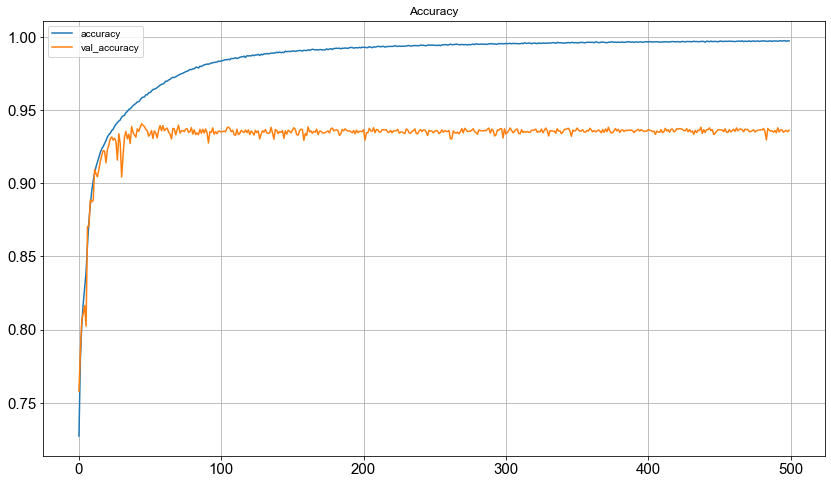

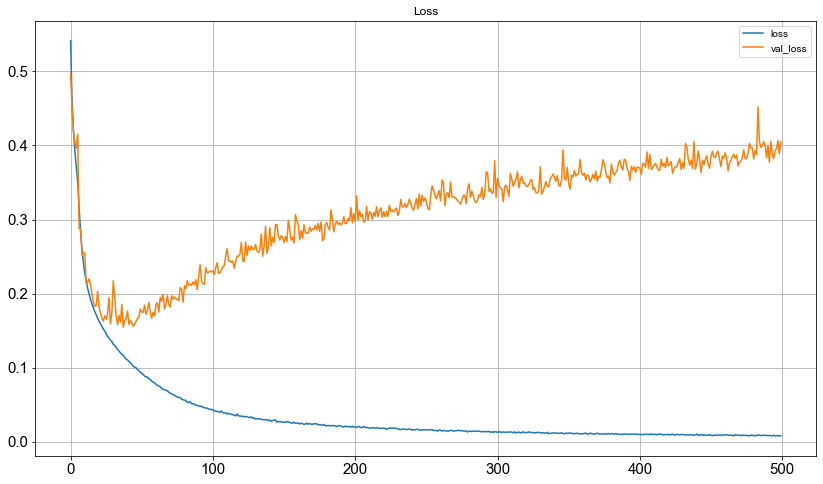

In [21]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

# Import Model and Classify Function Definition

In [ ]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

model = load_model('best_model_93.hdf5')
# model.summary()

def classify_emg(data):
    data = np.array(data) 
    data = np.reshape(data,(1,20,5))
    pred = model.predict(data,batch_size=1)[0]
#     print(pred)
    if(pred[0]>pred[1]):
        return 'Pronation'
    else:
        return 'Radial'

## Real time CNN Classifier Example
**Input Data** - The single Input data matrix sent in 20Khz freaquency,Has rows as time steps and columns as feature

### Input Sequence Data from DF

In [ ]:
# Total Pronation sequences = 330709
# Total Radial sequences = 148426 

sequence = 50 

df = pronation_df.reset_index(drop=True)
# df = radial_df.reset_index(drop=True)

data = df.loc[sequence*10:sequence*10+19] # The 20 step data Input Matrix
print('Input Data')
print(data.drop(['Label'],1).shape)
data

In [ ]:
print('True = ',data['Label'].tolist()[0])
data = data.drop(['Label'],1)
print('Predicted = ',classify_emg(data)) # Predict

### with Testing Dataset

In [ ]:
n = 2 
data = X_test[n] 
true = y_test[n]
print('Input shape = ',data.shape)


In [ ]:
if(true[0]==1):
    print('True = Pronation')
else:
    print('True = Radial')
print('Predicted = ',classify_emg(data)) # Predict